<a href="https://colab.research.google.com/github/XiangxiangXu/NFL/blob/main/H_score_Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# H-score: Exploring Dependence Between Sequential Observations

A demo for
[![blog](https://img.shields.io/badge/blog-gilearning.github.io-black)](https://gilearning.github.io/)

This is a supporting demo for [this post](https://gilearning.github.io/HScore/) on the H-score network. This demo illustrates how we use H-score to explore the dependence between high-dimensional data observations. Here we consider the sequential data, for example, speech/vibration measured by sensors. We will use H-score to learn the dependence between the readings collected by two sensors.



## Set up GPU for Training

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## Generate Sequential Observations

Let $\underline{\sf x} \triangleq (\mathsf{x}_1, \dots, \mathsf{x}_{l_x})$ and $\underline{\sf y} \triangleq (\mathsf{y}_1, \dots, \mathsf{y}_{l_y})$ denote the readings from two sensors, with lengths $l_x, l_y$, respectively.

Suppose the observation $\underline{\sf x}$ is induced by some physical event, denoted by a hidden variable $\sf u$. Similarly, $\underline{\sf y}$ is induced by another event, represented by a hidden variable $\sf v$. These two hidden variables $\sf u, v$ can be dependent. Mathematically, this says that $\underline{\sf x}$ and $\underline{\sf y}$ are dependent through the hidden variables $\sf u$ and $\sf v$, and we have the Markov relation $\underline{\mathsf{x}}-{\sf u-v}-\underline{\mathsf{y}}$.


For simplicity, we assume both $\sf u$ and $\sf v$ are binary, and the observations are also quantized as binary sequences.

In [ ]:
u_card = 2  # cardinality for u
v_card = 2  # cardinality for v

In [ ]:
x_card_sym = 2 # cardinality for each symbol in x sequence
y_card_sym = 2 # cardinality for each symbol in y sequence
len_x = 40 # l_x
len_y = 30 # l_y

In addition, we assume the $\underline{\sf x}$ sequence will have high frequency (switches between 0 and 1 frequently) if $\sf u = 1$, and will be low-freqency if $\sf u = 0$. Similarly, $\underline{\sf y}$ will be high-frequency if $\sf v = 1$, and will be low-freqency otherwise.

We use the following first-order Markov chain to simulate the sequences $\sf x$ and $\sf y$, where the freqeuncy is tuned by parameter $q \in [0, 1]$. A large $q$ will lead to a high frequency.



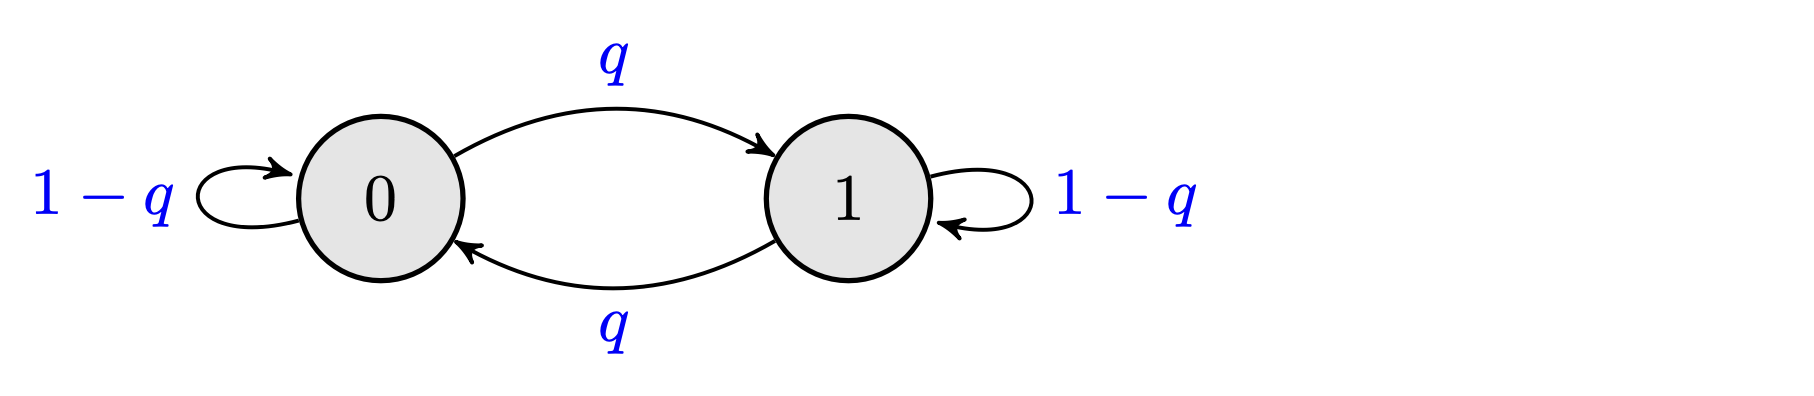

We use the following two values of $q$ to generate x and y sequences accoding to values of $\sf u, v$. For example, if $\sf u = 1$, $\sf x$ will be generated by the Markov chain with $q = q_1$.


In [ ]:
q0, q1 = (.1, .9)

The above generation processes can also be formally written as
$$\mathsf{x}_{i + 1} = \mathsf{x}_{i} + \mathsf{z}_{i},\quad i = 1, \dots, l_x - 1,$$
$$\mathsf{y}_{i + 1} = \mathsf{y}_{i} + \mathsf{z}'_{i}, \quad i = 1, \dots, l_y - 1,$$
where the plus "$+$" is defined as the modulo two sum, and the noise terms $\mathsf{z}_{i} \overset{\text{i.i.d.}}{\sim} \mathrm{Bern}(q_{\sf u})$ and  $\mathsf{z}'_{i} \overset{\text{i.i.d.}}{\sim} \mathrm{Bern}(q_{\sf v})$ are mutually indpendent.

We then set how hidden variables $\sf u$, $\sf v$ are dependent, by assigning a value for joint distribution $\mathtt{p\_vu}$.

In [ ]:
import numpy as np

p_vu = np.array([[.1, .2],
                 [.4, .3]])

# row indices   <-> different values of v
# colum indices <-> different values of u

# compute the marginal distributions
p_v = np.sum(p_vu, axis = 1)
p_u = np.sum(p_vu, axis = 0)


Parameters for training.

In [ ]:
# number of samples
nSamples_train = 50000
nSamples_test = 10000
nSamples = nSamples_train + nSamples_test


## Parameters for Training
# batch size
batchsize = 128

# number of epochs
nEpochs = 50

We first genearate $(\sf{u}, \sf{v})$ joint samples as we did in previous demos. Then we generate $\underline{\sf x}, \underline{\sf y}$ sequences as the corresponding first-order Markov chains parameterized by $\sf u, v$.

In [ ]:
"""
Generate random discrete samples
"""
def GenerateDiscreteSamples(p_xy, nSamples):
    '''
    generate n samples of (X, Y) pairs, with distribution p_xy
    '''
    (x_card, y_card) = p_xy.shape
    p_xy_vec = p_xy.reshape(-1)
    key = np.random.choice(range(x_card*y_card), nSamples, p=p_xy_vec)

    X = (key / y_card).astype(int)
    Y = (key % y_card)

    return([X, Y])


[V, U] = GenerateDiscreteSamples(p_vu, nSamples)

def GenBinSeq(q, len, n = 1):
    # generate n binary sequences with length len
    # j-th sequence take the form x[i+1] = x[i] + z[i]
    # where z[1]... z[n] are i.i.d., z[j] ~ Bern(q[j])
    # Input: q   -- length n list, Bernoulli parameter for each sequence
    #        len -- length of seqs
    #        n   -- number of seqs
    # Output: n by len matrix
    seq = (np.random.rand(n, len) < q.reshape(n, 1) * np.ones((1, len))) # all entries are Bern(p)
    seq = np.cumsum(seq, axis = 1)  # sum over rows
    seq = seq % 2 # module 2
    return seq


qx_vec = np.ones((1, nSamples)) * (q1 * U + q0 * (1-U))
qy_vec = np.ones((1, nSamples)) * (q1 * V + q0 * (1-V))
X = GenBinSeq(qx_vec, len_x, nSamples)
Y = GenBinSeq(qy_vec, len_y, nSamples)

Define dataset and dataloader.

In [ ]:
import torch.nn.functional as F
Xt = torch.tensor(X)
Xt = F.one_hot(Xt, x_card_sym).type(torch.FloatTensor)
Yt = torch.tensor(Y)
Yt = F.one_hot(Yt, y_card_sym).type(torch.FloatTensor)

from torch.utils.data import TensorDataset, DataLoader

# dataloder for training
ds = TensorDataset(Xt[:nSamples_train], Yt[:nSamples_train])
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)

# test data
X_test = X[nSamples_train:]
Y_test = Y[nSamples_train:]

# one-hot tensor
Xt_test = Xt[nSamples_train:]
Yt_test = Yt[nSamples_train:]
U_test = U[nSamples_train:]
V_test = V[nSamples_train:]

Let's first take a look at the binary sequences. With each row indicating one sequence pair, let's plot the first 10 pairs of $\sf x$ and $\sf y$ sequences.

<ipython-input-9-369aa41c4f8a>:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  a0.stem(X[i], use_line_collection = True)
<ipython-input-9-369aa41c4f8a>:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  a1.stem(Y[i], use_line_collection = True)


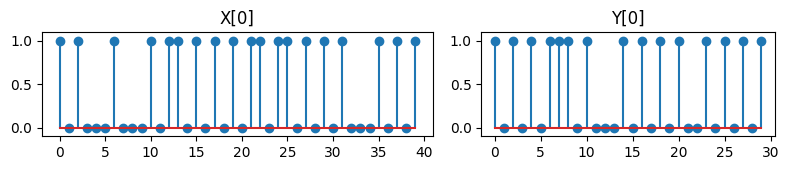

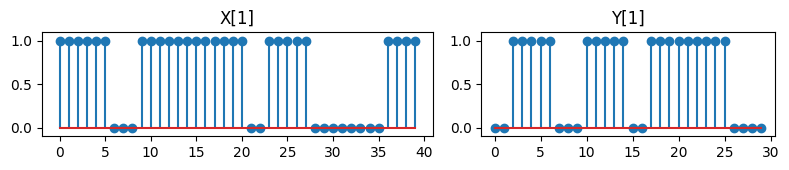

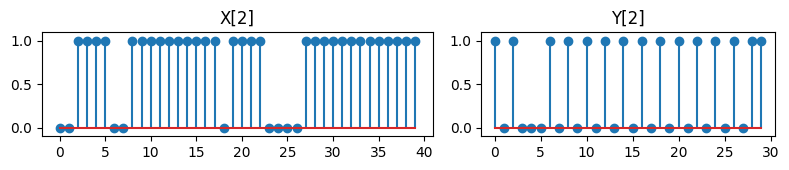

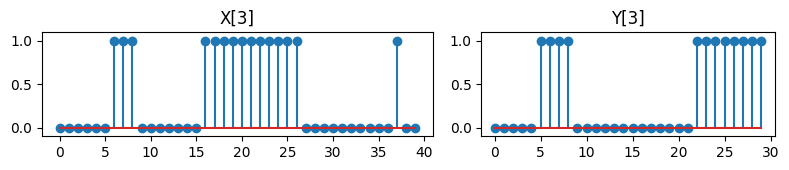

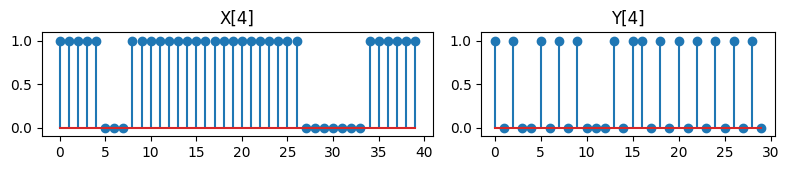

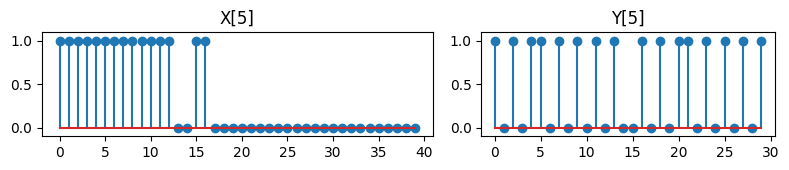

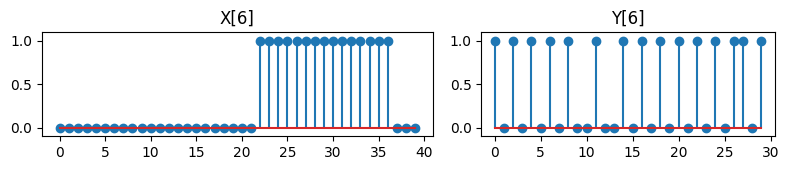

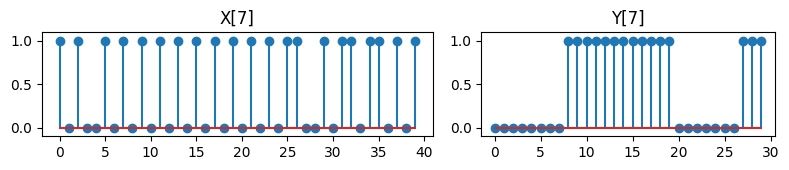

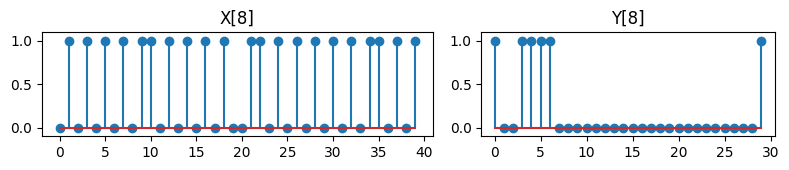

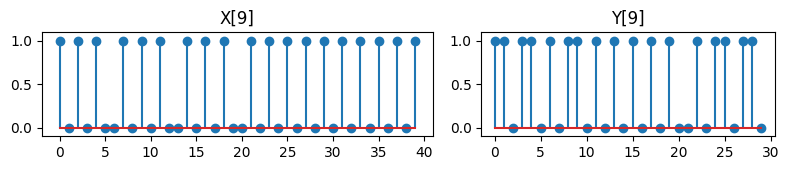

In [ ]:
from matplotlib import pyplot as plt

def plot_i_th_pair(i):
    fig, (a0, a1) = plt.subplots(1, 2, figsize=(8, 1.8), gridspec_kw={'width_ratios': [len_x, len_y]})
    a0.stem(X[i], use_line_collection = True)
    a0.set_title('X[' + str(i) + ']')
    a0.set_ylim([-0.1, 1.1])
    a1.stem(Y[i], use_line_collection = True)
    a1.set_title('Y[' + str(i) + ']')
    a1.set_ylim([-0.1, 1.1])
    fig.tight_layout()

for i in range(10):
    plot_i_th_pair(i)

## H-score Network and Trainning

Here we use one-dimensional convolutional neural networks to extract the features from sequences. Such networks are commonly used for [sentence classification](https://arxiv.org/abs/1408.5882).

The network architecture is defiend in the class $\mathtt{cnn\_seq}$.

In [ ]:
from torch import optim

import torch
import torch.nn as nn
import torch.nn.functional as F


class cnn_seq(nn.Module):
    """An 1D Convulational Neural Network for Sequence Processing."""
    # modified from https://colab.research.google.com/drive/1b7aZamr065WPuLpq9C4RU6irB59gbX_K#scrollTo=ejGLw8TKViBY
    def __init__(self,
                 input_dim,
                 embed_dim,
                 out_dim,
                 filter_size,
                 num_filters):
        """
        The constructor for cnn_seq class.

        Args:
            input_dim (int): Dimension of inputs
            embed_dim (int): Dimension of embedings.
            out_dim (int): Dimension of output features
            filter_size (int): filter size
            num_filters (int): number of filters
        """

        super(cnn_seq, self).__init__()
        # Embedding layer
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Conv Network
        self.conv1d = nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters,
                      kernel_size=filter_size)
        # Fully-connected layer
        self.fc = nn.Linear(num_filters, out_dim)

    def forward(self, x_input):
        """Perform a forward pass through the network.

        Args:
            x_input (torch.Tensor): input tensor with shape
                (batch_size, x_card_sym)

        Returns:
            f (torch.Tensor): Output features with shape (batch_size, out_dim)
        """

        # Get embeddings from inputs. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(x_input)

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and Relu. Output shape: (b, num_filters, L_out)
        #       L_out is the length of features after convolution
        x_conv = F.relu(self.conv1d(x_reshaped))

        # Avg pooling. Output shape: (b, num_filters, 1)
        x_pool = F.avg_pool1d(x_conv, kernel_size=x_conv.shape[2])

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, num_filters)
        x_fc = x_pool.squeeze(dim=2)

        # Compute features. Output shape: (b, out_dim)
        f = self.fc(x_fc)

        return f

class fg_nn(nn.Module): # f_net, g_net
    def __init__(self, f_net, g_net):
        super().__init__()
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, y):
        f = self.f_net(x)
        g = self.g_net(y)
        return f, g

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_g(self, y):
        g = self.g_net(y)
        return g


We set the parameters for the one-dimensional cnn. Note that here we only extract $k = 1$ dimensional feature ($\mathtt{out\_dim} = 1$).

In [ ]:
embed_dim = 4
filter_size = 4
num_filters = 32

out_dim = 1 # k = 1

f_net = cnn_seq(input_dim = x_card_sym, embed_dim = embed_dim, out_dim = out_dim, filter_size = filter_size, num_filters = num_filters)
g_net = cnn_seq(input_dim = y_card_sym, embed_dim = embed_dim, out_dim = out_dim, filter_size = filter_size, num_filters = num_filters)

model = fg_nn(f_net, g_net)
model.to(device)
opt = optim.Adam(model.parameters())

We maximize the H-score to train the neural feature extractors.

In [ ]:
centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

# define a function for training
def train(model, dataloder, loss_func, optimizer, nEpochs):
    for epoch in range(nEpochs):
        if epoch % 10 == 0:
            print("Epoch " + str(epoch) + '/' + str(nEpochs))
        for x, y in dataloder:
            f, g = model(x.to(device), y.to(device))
            loss = loss_func(f, g)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

print("Train:")
train(model = model, dataloder = dl, loss_func = neg_hscore, optimizer = opt, nEpochs = nEpochs)

Train:
Epoch 0/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50


## Analyizing Dependence Structure From Features

First, let's extract features from the test data and take a look at their distributions.

In [ ]:
f_test = f_net(Xt_test.to(device)).cpu().detach().numpy()
g_test = g_net(Yt_test.to(device)).cpu().detach().numpy()

# whiten
from scipy.cluster.vq import whiten
f_test = whiten(f_test)
g_test = whiten(g_test)

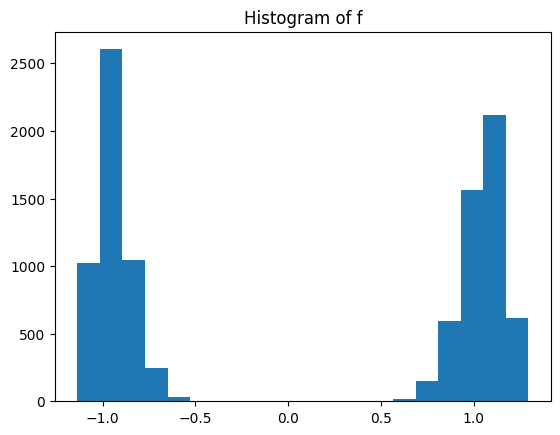

In [ ]:
plt.hist(f_test, bins = 20)[-1]
plt.title("Histogram of f")
plt.show()

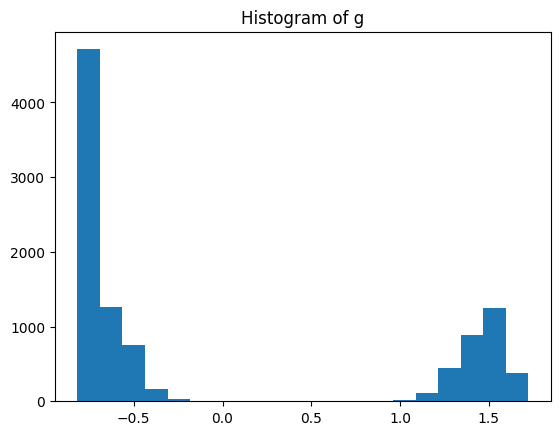

In [ ]:
plt.hist(g_test, bins = 20)[-1]
plt.title("Histogram of g")
plt.show()

We can note that both $f(\underline{\sf x})$ and $g(\underline{\sf y})$ form two clusters. We may guess that one cluster corresponds to high-frequency sequences, and the other is high-frequency sequences.

If this is the case, when we plot the pair $(f(\underline{\sf x}), g(\underline{\sf y}))$ on a plane, we shall see four clusters, which corresponds to all four combinations of x sequence and y sequence:



Text(0, 0.5, 'g(y)')

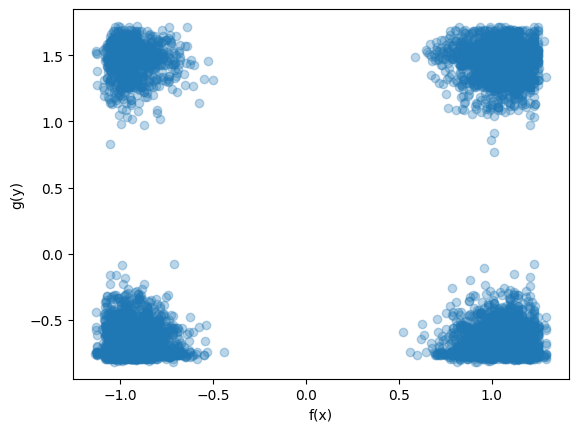

In [ ]:
plt.figure()
len_plot = nSamples_test # number of points to plot
f_test_plot = f_test[:len_plot]
g_test_plot = g_test[:len_plot]
plt.scatter(f_test_plot, g_test_plot, alpha = .3)
plt.xlabel('f(x)')
plt.ylabel('g(y)')

As expected, the feature pairs are well-clustered on four corners. We further apply k-menas clustering algorithm to get these clusters, and plot the feature pairs in differnt colors.

Text(0, 0.5, 'g(y)')

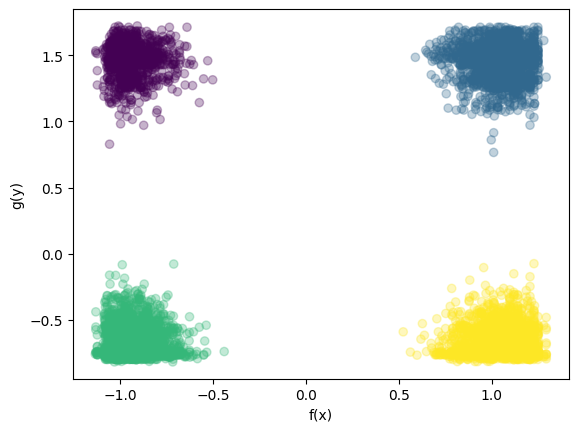

In [ ]:
from scipy.cluster.vq import kmeans2
f_min = np.min(f_test_plot)
f_max = np.max(f_test_plot)
g_min = np.min(g_test_plot)
g_max = np.max(g_test_plot)
centroid_initial = np.array([[f_min, g_max],
                             [f_max, g_max],
                             [f_min, g_min],
                             [f_max, g_min]])
centroid, label_kmeans = kmeans2(np.concatenate([f_test_plot, g_test_plot], axis = 1), centroid_initial, minit='matrix')

# plot
plt.figure()
plt.xlabel('f')
plt.ylabel('g')
plt.scatter(f_test_plot,
            g_test_plot,
            c = label_kmeans,
            alpha = .3)
plt.xlabel('f(x)')
plt.ylabel('g(y)')

Then we can count the number of points in these clusters and get the proportion of each cluster.

In [ ]:
_, counts = np.unique(label_kmeans, return_counts=True)

with np.printoptions(precision=2, suppress=True):
    print('proportion = \n', counts.reshape(v_card, u_card)/len_plot)

proportion = 
 [[0.11 0.2 ]
 [0.39 0.3 ]]


This should correspond to the dependence between hidden variables $\sf u$, $\sf v$, up to the some permutation of rows and columns:

In [ ]:
p_vu

array([[0.1, 0.2],
       [0.4, 0.3]])

Of course, we can also directly compare the clustering results with the ture label $\sf (u, v)$. Let's plot the feature pairs again, but use the true label to color the points. This should give us the same cluster.

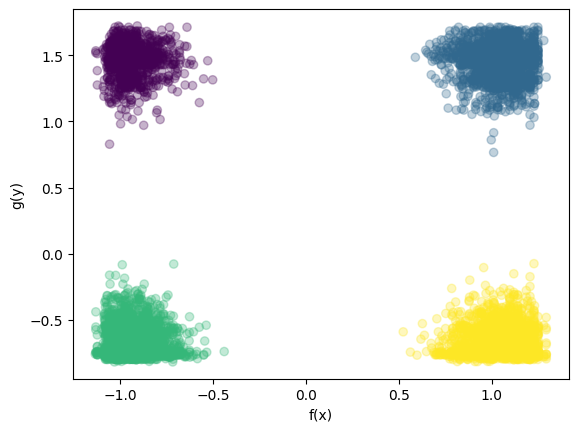

In [ ]:
label_uv = V_test*2 + U_test
plt.figure()
#len_plot = len(f_test) # number of points to show
plt.xlabel('f(x)')
plt.ylabel('g(y)')
plt.scatter(f_test,
            g_test,
            c = label_uv,
            alpha = .3)

## Ultimate Test: Are the learned featues theoretically optimal?

We have already seen that we can obtain the dependence structure by optimizing H-score. Since we only used some common neural archetecture without much tuning, one may ask to which extend the extracted featurs are optimal. Here is the ultimate test: as we know the statistical model behind the sequences, we can compute the the optimal features defined by modal decomposition, or maximal correlation functions. Then we can compare our extracted features with the theoretical ones.

With some math, we can obtain the analyitical expression of maximal correlation function, which we then compute using $\mathtt{max\_corr\_seq}$.

In [ ]:
def max_corr_seq(x, c, gamma = 0):
    """
    x: n x len matrix,
        n   - number of seqs
        len - sequence length
    c: scalar

    Output:
        maximal correlation function
    """
    n, len = x.shape
    d_vec = np.sum((x[:, 1:] - x[:, :-1] + 1) % 2, axis = 1, keepdims = True)
    return np.tanh(c * ((len-1)/2 - d_vec) + gamma / 2) - np.tanh(gamma/ 2)

In [ ]:
c = np.log(q1/q0)

comp_gamma = lambda p: np.log(p[1]/p[0])
gamma_X = comp_gamma(p_u)
gamma_Y = comp_gamma(p_v)
f_opt_test = max_corr_seq(X_test, c, gamma_X)
g_opt_test = max_corr_seq(Y_test, c, gamma_Y)

Finally, we can compute the angle (correlation coefficient) between extracted feature and theoretically optimal one.

In [ ]:
# compute the correlation coefficients between x, y
corr = lambda x, y: (np.corrcoef(x.reshape(-1), y.reshape(-1)))[0, 1]

corr_f = corr(f_test, f_opt_test)
corr_g = corr(g_test, g_opt_test)

print('cos(f_learned, f*) =', round(corr_f, 3))
print('cos(g_learned, g*) =', round(corr_g, 3))

cos(f_learned, f*) = 0.995
cos(g_learned, g*) = -0.994


## Final Remark on Feature Dimensions
Up to this point, we see how to use neural nets to extract dependence modes. Both the data and model are simplified for better demonstration.

However, one may be wondering why we (can) use only $k = 1$ dimension features while still obtain meaningful results. Or, would a larger $k$ give us more information about the data? After all, as we illustrated in [the post](https://gilearning.github.io/HScore/), using $k$-dimensional feature will give us the top-$k$ modes of the dependence.

The good news is that we can indeed prove the dependence between $\underline{\sf{x}}$ and $\underline{\sf y}$ has only one mode. Therefore, one-dimensional features can capture all the dependence between them. Even we use more dimensions, we will find the extracted features colinear.

In practice, our goal is often to obtain efficient feature representations, and avoid such colinear effects. More generally, if we can extract the dependence modes as ordered in the modal decomposition, we will obtain modes ordered by their importance, which naturally avoids colinear features. To this end, we will introduce a new tool, the nested H-score, in our [next post](https://gilearning.github.io/NestedHScore/). We will also have a demo based on the same sequential dataset, which can be found [here](https://colab.research.google.com/drive/1JtjS1LfWpf0eWx3xWTKYlW1myCTE4vqb#scrollTo=quVfOLn-fR_x).